
## Regular Gridded Data Structures / ndarrays in Python for Engineers and Geoscientists 
### Michael Pyrcz, Associate Professor, University of Texas at Austin 

#### Contacts: [Twitter/@GeostatsGuy](https://twitter.com/geostatsguy) | [GitHub/GeostatsGuy](https://github.com/GeostatsGuy) | [www.michaelpyrcz.com](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446)

This is a tutorial for / demonstration of **Regular Gridded Data Structures in Python**.  In Python, a common tool for dealing with Regular Gridded Data Structures is the *ndarray* from the **NumPy Python package** (by Jim Hugunin et al.).    

This tutorial includes the methods and operations that would commonly be required for Engineers and Geoscientists working with Regularly Gridded Data Structures for the purpose of:

1. Data Checking and Cleaning
2. Data Mining / Inferential Data Analysis
3. Predictive Modeling

for Data Analytics, Geostatistics and Machine Learning.

##### Regular Data Structures

In Python we will commonly store our data in two formats, tables and arrays.  For sample data with typically multiple features $1,\ldots,m$ over $1,\ldots,n$ samples we will work with tables.  For exhaustive 2D maps and 3D models (usually representing a single feature) on a regular grid over $[1,\ldots,n_{1}], [1,\ldots,n_{2}],\ldots,[1,\ldots,n_{ndim}]$, where $n_{dim}$ is the number of dimensions, we will work with arrays.  Of course, it is always possible to add another dimension to our array to include multiple features, $1,\ldots,m$, over all locations.

In geostatistical workflows the tables are typically sample data from wells and drill holes and the grids are the  interpolated or simulated models or secondary data from sources such as seismic inversion.

The NumPy package provides a convenient *ndarray* object for working with regularly gridded data. In the following tutorial we will focus on practical methods with *ndarray*s.  There is another section available on Tabular Data Structures that focuses on DataFrames at https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/PythonDataBasics_DataFrame.ipynb.

#### Project Goal

Learn the basics for working with Regular Gridded Data Structures in Python to build practical subsurfrace modeling and machine learning workflows.

#### Caveats

I included methods that I have found useful for building my geo-engineering workflows for subsurface modeling. I think they should be accessible to most geoscientists and engineers.  Certainly, there are more advanced, more compact, more efficient methods to accomplish the same tasks.  I tried to keep the methods simple.  I appreciate feedback and I will use it to improve this tutorial periodically.

#### Load the required libraries

The following code loads the required libraries.


In [ ]:
import os                                                   # set current working directory 
import numpy as np                                          # ndarrays
import matplotlib.pyplot as plt                             # plotting
from scipy import stats                                     # summary stats

If you get a package import error, you may have to first install some of these packages. This can usually be accomplished by opening up a command window on Windows and then typing 'python -m pip install [package-name]'. More assistance is available with the respective package docs.  

#### Declare functions

These are the functions we have included here:

1. GSLIB2ndarray - load GSLIB Geo-EAS format regular grid data 1D or 2D to NumPy *ndarray*
2. ndarray2GSLIB - write NumPy array to GSLIB Geo-EAS format regular grid data 1D or 2D
3. pixelplt - plot 2D NumPy arrays with same parameters as GSLIB's pixelplt 

I include and demonstrate the GSLIB Geo-EAS file read and write functions, because (1) *ndarray* read and write member functions are convenience functions that are limited and (2) for geostatistical modeling it is conveneint to read and write from Geo-EAS the format used in GSLIB by Deutsch and Journel (1998). Also, I included a function that reimpliments the 2D array plotting program 'pixelplt' from GSLIB.  The inputs are simple and the method is consistent with GSLIB, and by using it we postpone having to learn the MatPlotLib package for plotting.

Warning, there has been no attempt to make these functions robust in the precense of bad inputs.  If you get a crazy error check the inputs.  Are the arrays the correct dimension?  Is the parameter order mixed up?  Make sure the inputs are consistent with the descriptions in this document.

In [ ]:
# utility to convert 1D or 2D numpy ndarray to a GSLIB Geo-EAS file for use with GSLIB methods   
def ndarray2GSLIB(array,data_file,col_name):
    file_out = open(data_file, "w")
    file_out.write(data_file + '\n')  
    file_out.write('1 \n')  
    file_out.write(col_name  + '\n') 
    if array.ndim == 2:
        ny = (array.shape[0])
        nx = (array.shape[1])
        ncol = 1
        for iy in range(0, ny):
            for ix in range(0, nx):
                file_out.write(str(array[ny-1-iy,ix])+ '\n')        
    elif array.ndim == 1:
        nx = len(array)        
        for ix in range(0, nx):
            file_out.write(str(array[ix])+ '\n')             
    else:       
        Print("Error: must use a 2D array")            
        file_out.close()
        return            
    file_out.close()

# utility to convert GSLIB Geo-EAS files to a 1D or 2D numpy ndarray for use with Python methods
def GSLIB2ndarray(data_file,kcol,nx,ny): 
    colArray = []
    if ny > 1:
        array = np.ndarray(shape=(ny,nx),dtype=float,order='F')
    else:
        array = np.zeros(nx)    
    with open(data_file) as myfile:   # read first two lines
        head = [next(myfile) for x in range(2)]
        line2 = head[1].split()
        ncol = int(line2[0])          # get the number of columns
        for icol in range(0, ncol):   # read over the column names
            head = [next(myfile) for x in range(1)]
            if icol == kcol:
                col_name = head[0].split()[0]       
        if ny > 1:
            for iy in range(0,ny):
                for ix in range(0,nx):
                    head = [next(myfile) for x in range(1)]
                    array[ny-1-iy][ix] = head[0].split()[kcol]
        else:
            for ix in range(0,nx):
                head = [next(myfile) for x in range(1)]
                array[ix] = head[0].split()[kcol]
    return array,col_name
    
# pixel plot, reimplemention in Python of GSLIB pixelplt with MatPlotLib methods (commented out image file creation)
def pixelplt(array,xmin,xmax,ymin,ymax,step,vmin,vmax,title,xlabel,ylabel,vlabel,cmap,fig_name):
    xx, yy = np.meshgrid(np.arange(xmin, xmax, step),np.arange(ymax, ymin, -1*step))
    plt.figure(figsize=(8,6))
    im = plt.contourf(xx,yy,array,cmap=cmap,vmin=vmin,vmax=vmax,levels=np.linspace(vmin,vmax,100))
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    cbar = plt.colorbar(im,orientation = 'vertical',ticks=np.linspace(vmin,vmax,10))
    cbar.set_label(vlabel, rotation=270, labelpad=20)
#    plt.savefig(fig_name + '.' + image_type,dpi=dpi)
    plt.show()
    return im

#### Set the working directory

I always like to do this so I don't lose files and to simplify subsequent read and writes (avoid including the full address each time).  Also, in this case make sure to place the required (see below) data file in this directory.  When we are done with this tutorial we will write our new dataset back to this directory.  

In [ ]:
os.chdir("c:/PGE383")                                       # set the working directory

#### Loading and Writing

Let's load the 2D porosity map from the provide binary file.  This file was created with the NumPy *ndarray* member function 'tofile'.  Note: this and the read from file member function, *fromfile*, are convenience functions.  They do not store any information about the array. So when we read our 100 x 100 array this results in a 10,000 1D array.  Let's try for ourselves. We can read the binary to an array like this:

In [ ]:
porosity_map = np.fromfile('porosity_truth_map.dat')

Next, let's look at the shape member:

In [ ]:
porosity_map.shape

Confirmed, the shape is (10000,), a 10,000 node 1D array.  Given we know it is actually a 100x100 array, we can use the *ndarray* member function *reshape* to correct this.  Note, you get an error if the sizes are inconsistent, $\prod^{i} n_{i} \neq n_{1D}$ where $n_{i}$ is the number of nodes for axis $i$ and $n_{1D}$ is the number of nodes in the 1D vector that was read in.  We reshape the array to 100x100, print the results and then get the 'ndarray' member 'shape' elements 0 and 1 to confirm the $n_{1} = n_{2} = 100$.

In [ ]:
porosity_map = np.reshape(porosity_map,[100,100])                # reshape the array to 100 x 100
print(porosity_map.shape)
ny = porosity_map.shape[0]                                       # get the array nx
nx = porosity_map.shape[1]                                       # get the array ny
print('Our 2D array has number of x cells = ' + str(nx) + ', and y cells = ' + str(ny) + '.' )

Let's close the loop and write out the array and read it back in, to demonstrat the *ndarray* writing member function *tofile*.  

In [ ]:
porosity_map.tofile("porosity_test.dat")                         # save our 2D array to a 1D binary file
porosity_test = np.fromfile('porosity_test.dat')                 # read the 1D binary back to a 1D array
check = np.array_equal(porosity_map.flatten(),porosity_test)     # check if the read in array is the same as flatten orig.
print('The array we wrote out and read back in are the same, we closed the loop,' + str(check) + '.')

It worked!  We used the NumPy function 'array_equal' to test if the arrays are the same. Did you notice I added the *flatten* member function?  This caused the 100x100 'porosity_map' array to be passed to the *array_equal* as a 10,000 node 1D array, the same as 'porosity_test'  array was loaded.  We can write an array and read it back in and we get the same thing.  

Let's check out using .csv files to store a 2D ndarray.

In [ ]:
np.savetxt("porosity_map.csv", porosity_map, delimiter=",")

The 2D ndarray is saved with each line containing a row and each column delimited by a comma.  In this format the 2D grid can be directly loaded into Excel.  One can use conditional formatting to conduct a very quick check of the 'look' of the data.  E.g. confirm that it is not upside down, scrambled etc.

In [ ]:
porosity_map_test = np.loadtxt("porosity_map.csv", delimiter=",") # load the csv file back into a 2D ndarray
test = np.array_equal(porosity_map,porosity_map_test)             # check if the arrays are the same
print(test)

OK, we confirmed that the save and reloaded 2D ndarray is the same as the original 2D ndarray. This save and load method works.  Lets perform the same test for the included GeostatsPy functions to save and load gridded data in Geo-EAS format (this is the format used by GSLIB programs).

In [ ]:
ndarray2GSLIB(porosity_map,"porosity_map_GSLIB.out","porosity")   # save the gridded data to Geo-EAS format
porosity_map_test2, col_name = GSLIB2ndarray("porosity_map_GSLIB.out",0,nx,ny)
test = np.array_equal(porosity_map,porosity_map_test2)             # check if the arrays are the same
print(test)

OK, we confirmed that the GeostatsPy methods for saving and loading 2D gridded data work.  

#### Visualization

Let's look at the dataset that we loaded.  Instead of working with the MatPlotLib package directly (common data visualization package for Python) we will use the *pixelplt* reimplimentation from our set of functions from my effort to bring GSLIB to Python, the 'in-progress' GeostatsPy package.  This function uses MatPlotLib with the function parameters to build a nice figure, so we can  procastinate learning MatPlotLib for now!  First let's set some parameters, including the spatial limits of the plot, the cell sizes in the plot and the min and max feature values and color map for the color bar.  Our regular grid is 100 x 100 cells of 10 m cells (i.e. squares), 1,000 x 1,000 m in extents and we assume the origin, low left corder is at coordinate 0,0.  Our porosity values are contained within the interval between 4 to 16%. 

In [ ]:
xmin = 0.0;xmax = 1000.0; ymin = 0.0; ymax = 1000.0; cell_size = 10.0; vmin = 4.0; vmax = 16.0; cmap = plt.cm.plasma 

Now we are ready to plot the 2D array with the *pixpelplt* reimplementation from our GSLIB in Python.

In [ ]:
pixelplt(porosity_map,xmin,xmax,ymin,ymax,cell_size,vmin,vmax,"Porosity Truth Map","X(m)","Y(M)","Porosity (%)",cmap,"Porosity_Map")

The NumPy package *ndarray* docs recommend that users consider making their own functions to read and write *ndarray*s from ASCII files.  We have coded functions to do this using the GSLIB Geo-EAS format, to support geostatistical workflows that utilize GSLIB programs as part of the GeostatsPy package that we are developing.  We included the read and write functions here for this tutorial.   

You can look at a truncated representation of the *ndarray* like this.  Sometimes a good way to check data is to just look at it.

In [ ]:
print(porosity_map)

You can see that the 2D array is actually an array of arrays, e.g. an array of $1,\ldots,n_{x}$ of arrays of $1,\ldots,n_{y}$.  To show this we can include an index for x and we will get a slice for all values with equal $x$ index.  Let's look at the the first slice of $y$ values with x index equal to zero.

In [ ]:
porosity_map[0]

If we add another index we get a single node from the 2D array.  Let's get the first and last values from this slice with $x$ index equal to zero.  We will print them and you can confirm they are the first and last values from the output above.

In [ ]:
print(porosity_map[0][0])                                        # get first and last value for ix = 0 slice
print(porosity_map[0][99])

Alternatively, you can use this notation to access a single cell in a *ndarray*.

In [ ]:
print(porosity_map[0,0])                                         # get first and last value for ix = 0 slice
print(porosity_map[0,99])

You could get access to a range of values of the array like this (see below).  We get the results for *porosity_map* indices $ix = 0$ and $iy = 0,1,\ldots,9$.

In [ ]:
print(porosity_map[0][0:10])                                     # get first 10 values for the ix = 0 slice

If you want to see the entire array without truncated representation then you change the print options threshold in NumPy to a *NaN* like this.  Note, this is probably not a good idea if you are working with very large arrays.  For this example you can literally look through 10,000 values!

In [ ]:
np.set_printoptions(threshold=np.nan)                            # remove truncation from array visualization
print(porosity_map)

#### Summary Statistics

Let's try some summary statistics.  Here's a convenient method from SciPy. Like many of the methods it anticipates a 1D array so we do a *flatten* on the 2D array to convert it to a 1D array before passing it.   

In [ ]:
stats = stats.describe(porosity_map.flatten())                   # array summary statistics
stats

We also have a variety of built in summary statistic calculations that we may apply on *ndarray*s.  Note, these methods work directly with our 2D array; therefore, do not require flatening to a 1D array.

In [ ]:
mean_por = porosity_map.mean()                                   # array summary statistics
stdev_por = porosity_map.std()
min_por = porosity_map.min()
max_por = porosity_map.max()
print('Summary Statistics of Porosity \n Mean = ' + str(mean_por) + ', StDev = ' + str(stdev_por))
print(' Min = ' + str(min_por) + ', Max = ' + str(max_por))

We can also do this with NumPy functions that work with arrays that calculate the previous summary statistics and more.  

In [ ]:
mean_por = np.mean(porosity_map)                                 # array summary statistics
stdev_por = np.std(porosity_map)
min_por = np.min(porosity_map)
max_por = np.max(porosity_map)
P10_por,P90_por = np.percentile(porosity_map,[0.10,0.90])
print('Summary Statistics of Porosity \n Mean = ' + str(mean_por) + ', StDev = ' + str(stdev_por))
print(' Min = ' + str(min_por) + ', Max = ' + str(max_por))
print(' P10 = ' + str(P10_por) + ', P90 = ' + str(P90_por))

#### Checking and Manipulating

We can read and write individual value of our array with indices $ix = 0,\ldots,nx-1$ and  $iy = 0,\ldots,ny-1$.

In [ ]:
local_por = porosity_map[0,0]                                    # get porosity at location 0,0
print('Porosity at location 0,0 in our ndarray is ' + str(local_por) + '.')
porosity_map[0,0] = 10.0000                                      # change the porosity value at location 0,0
print('Porosity at location 0,0 in our ndarray is now ' + str(porosity_map[0,0]) + '.')

We can also check for *NaN*s, invalid or missing values in our *ndarray*.  

In [ ]:
porosity_map[0,0] = np.nan
print('Porosity at location 0,0 in our ndarray is now ' + str(porosity_map[0,0]) + '.')

We can check for any *NaN*'s in our array with the following code.  First, let's add a couple more *NaN* values to make this example more interesting.

In [ ]:
porosity_map[0,1] = np.nan                                       # add another NaN
porosity_map[2,1] = np.nan                                       # add another NaN
result = np.isnan(porosity_map).any()
result

Ok, so now we kown that we have *NaN*'s in our array.  This could cause issues with our calculations.  We can get a list of indices with *NaN*'s in our *ndarray*. 

In [ ]:
nan_list = np.argwhere(np.isnan(porosity_map))                   # get list of indices of array with NaNs
print(nan_list)

We now have a list of the indices (0,0), (0,1) and (2,1) with *NaN*'s.  This is exactly the array indices that we assigned to NaN.  If you convert this list of indices by mapping them with *map* to *tuple*s and make that into a new list we get something we can use to directly interact with the *NaN*'s in our 2D *ndarray*.

In [ ]:
nan_list_tuple = list(map(tuple, nan_list))                      # convert index list to tuple list 
print(nan_list_tuple)                                            # check the tuple list
print(porosity_map[nan_list_tuple[0]])                           # get the values at the indices
print(porosity_map[nan_list_tuple[1]])
print(porosity_map[nan_list_tuple[2]])

Now that we have this list of array coordinate, list of tuples, we can use this to actually access those locations.  Here we use those locations (there should be 3 *NaN*'s) to replace the missing values with very small porosity values (0.0001).

In [ ]:
print('Value at the first NaN indices is ' + str(porosity_map[nan_list_tuple[0]]) + '.') # get value at first index
porosity_map[nan_list_tuple[0]] = 0.001                          # set the NaN's to a low porosity value
porosity_map[nan_list_tuple[1]] = 0.001
porosity_map[nan_list_tuple[2]] = 0.001
print('Value at the first NaN indices after setting to 0.001 is ' + str(porosity_map[nan_list_tuple[0]]) + '.')

#### Making Arrays

There are various methods to make *ndarray*s from scratch.  In some cases, our arrays are small enough we can just write them like this.

In [ ]:
my_array = np.array([[0,1,2],[4,5,6],[7,8,9]])                   # make an ndarray by scratch
print(my_array.shape)
my_array

We now have a 3 x 3 *ndarray*.

We can also use NumPy's *rand* to make an *ndarray* of any shape with random values between 0 and 1 and *zeros* to make an array of any shape with 0's. 

In [ ]:
from scipy import stats                                          # summary stats
rand_array = np.random.rand(100,100)                             # make 100 x 100 node array with random values
print('Shape of the random array = ' + str(rand_array.shape))
print(stats.describe(rand_array.flatten()))
pixelplt(rand_array,xmin,xmax,ymin,ymax,cell_size,0,1,"Random Values","X(m)","Y(M)","Random",cmap,"random")

zero_array = np.zeros((100,100))                                 # make 100 x 100 node array with zeros
print('Shape of the zero array = ' + str(zero_array.shape))
print(stats.describe(zero_array.flatten()))
pixelplt(zero_array,xmin,xmax,ymin,ymax,cell_size,-1,1,"Zeros","X(m)","Y(M)","Zeros",cmap,"zeros")

#### Operations

We can search for values in our array with any criteria we like.  In this example we identify all nodes with porosity values greater than 15%, the result of *porosity > 15.0* is a boolean array (true and false) with true when that criteria is met.  We apply that to the *porosity_map* *ndarray* to return all node values with true in a new array.  We can check the size of that array to get the total number of nodes with porosity values greater than 15.   

In [ ]:
greater_than = porosity_map[porosity_map > 15.0]                 # make boolean array and get values that meet criteria
print(greater_than)
print('There are ' + str(greater_than.size) + ' of a total of ' + str(porosity_map.flatten().size) + '.')

We can actually plot the boolean array (true = 1 and false = 0 numerically) to get a map of the nodes that meet the criteria.  We do that below with porosity > 13% because it looks more interesting than only 25 nodes for the porosity > 15% case.

In [ ]:
thresh_porosity_map = porosity_map > 13.0
pixelplt(thresh_porosity_map,xmin,xmax,ymin,ymax,cell_size,0,1,"Porosity > 13%","X(m)","Y(M)","Boolean",cmap,"threshold")

How would you get a list of the indices that meet the criteria in the *porosity map* array?  We repeat the command to make a list of tuples with locations with porosity > 15%, *loc_hig_por*.  Then we simply grab the ix and iy index values from this list.  The list is set up like this, my_list[0 for ix, 1 for iy][1 to number of nodes]

In [37]:
loc_high_por = np.nonzero(porosity_map > 15)                    # get the indices with high porosity 
print('Loc #1, ix = ' + str(loc_high_por[1][0]) + ' and iy = ' + str(loc_high_por[0][0]) + '.')
print(' With a value of ', str(porosity_map[loc_high_por[0][0],loc_high_por[1][0]]) + '.')
print('Loc #2, ix = ' + str(loc_high_por[1][1]) + ' and iy = ' + str(loc_high_por[0][1]) + '.') 
print(' With a value of ', str(porosity_map[loc_high_por[0][1],loc_high_por[1][1]]) + '.')

Loc #1, ix = 82 and iy = 34.
 With a value of  15.065366670432317.
Loc #2, ix = 88 and iy = 37.
 With a value of  15.057380096119918.


In [38]:
loc_high_por

(array([34, 37, 38, 50, 50, 57, 59, 63, 63, 63, 65, 65, 65, 65, 66, 66, 66,
        66, 66, 66, 81, 81, 82, 82, 84], dtype=int64),
 array([82, 88, 87, 83, 84, 89, 82, 83, 86, 87, 75, 79, 82, 83, 69, 70, 74,
        75, 78, 79, 66, 67, 66, 67, 68], dtype=int64))

Perhaps you want to do something more creative with your *ndarray*.  The most flexible approach is to use a loop and iterate over the array.  Let's add noise to our porosity map.  To do this we take the previously calculated random array and center it (set the mean to 0.0 by subtracting the current mean), we will multiply it by a factor of 5 so that the result is more noticable and add it to the *porosity_map* array. 

DescribeResult(nobs=10000, minmax=(0.2943955412382694, 17.5222066796764), mean=10.015014588520044, variance=6.123237021433289, skewness=0.06359438025667884, kurtosis=-0.350145166325619)


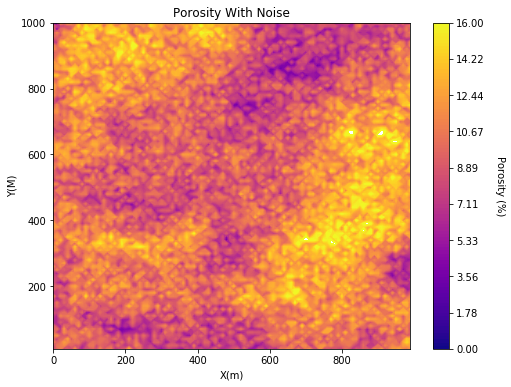

In [39]:
porosity_map_noise = np.zeros((100,100))                        # use of loops to maniputale ndarrays
for iy in range(ny):
    for ix in range(nx):
        porosity_map_noise[iy,ix] = porosity_map[iy,ix] + (rand_array[iy,ix]-0.5)*5
     
print(stats.describe(porosity_map_noise.flatten()))
pixelplt(porosity_map_noise,xmin,xmax,ymin,ymax,cell_size,0,16,"Porosity With Noise","X(m)","Y(M)","Porosity (%)",cmap,"Residual")

We could have done the above without the loops, by using the simple statement below.  We can use algebriac operators on *ndarray*s like this example below if the *ndarray* are all the same size. 

DescribeResult(nobs=10000, minmax=(0.2943955412382694, 17.5222066796764), mean=10.015014588520044, variance=6.123237021433289, skewness=0.06359438025667884, kurtosis=-0.350145166325619)


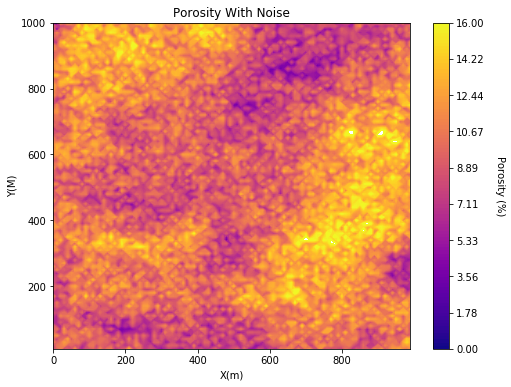

In [41]:
porosity_map_noice2 = porosity_map + (rand_array-0.5) * 5        # using matrix algebra to repeat the previous looped method
print(stats.describe(porosity_map_noise.flatten()))
pixelplt(porosity_map_noise,xmin,xmax,ymin,ymax,cell_size,0,16,"Porosity With Noise","X(m)","Y(M)","Porosity (%)",cmap,"Residual2")

Let's write our new *ndarray* to a file for storage and to apply with other software such as GSLIB.

In [42]:
ndarray2GSLIB(porosity_map_noise,"porosity_noise_GSLIB.dat","porosity_noise")   # write out 2D array to a Geo-DAS ASCII file

#### More Exercises

There are so many more exercises and tests that one could attempt to gain experience with the NumPy package, *ndarray* objects in Python. I'll end here for brevity, but I invite you to continue. Check out the docs at https://docs.scipy.org/doc/numpy-1.14.0/reference/arrays.ndarray.html.  I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin
On twitter I'm the @GeostatsGuy.
